# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter

### Read data into one big dictionary

In [2]:
os.chdir("./data")
study_data_names = [file for file in glob.glob("*.csv")]
os.chdir("..")
data = {0:{}, 1:{}}
for file in study_data_names:
    if(file.startswith('0')):
        group = 0
        index_questionnaire_end = 27
    else:
        group = 1
        index_questionnaire_end = 29
    data[group][file] = {}
    df = pd.read_csv("./data/" + file, quotechar="\"", names = ["question", "answer1", "answer2", "answer3"])
    if df.shape[0] == 10:
        df_songs = df
        df_songs["correct"] = ["WINNER" if s == "False" else "LOSER" for s in df_songs["answer1"]]
        df_songs.columns = ["song", "is_last", "human", "with_ai", "correct"]
        data[group][file]["songs"] = df_songs
    else:
        df_songs = df.loc[0:9]
        df_songs["correct"] = ["WINNER" if s == "False" else "LOSER" for s in df_songs["answer1"]]
        df_songs.columns = ["song", "is_last", "human", "with_ai", "correct"]
        data[group][file]["songs"] = df_songs
        df_quests = df.loc[10:index_questionnaire_end][["question","answer1","answer2"]]
        df_quests.columns = ["question", "answer","detail"]
        data[group][file]["questionnaire"] = df_quests
        times = df[index_questionnaire_end+1:].values[0][:3]
        times = [float(t.strip()) for t in times]
        diff_times = [times[1]-times[0], times[2]-times[1]]
        data[group][file]["times"] = diff_times

/var/folders/ky/d01ywblx1l5fk6g19868_t7m0000gn/T/ipykernel_87830/4064717291.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_songs["correct"] = ["WINNER" if s == "False" else "LOSER" for s in df_songs["answer1"]]
/var/folders/ky/d01ywblx1l5fk6g19868_t7m0000gn/T/ipykernel_87830/4064717291.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_songs["correct"] = ["WINNER" if s == "False" else "LOSER" for s in df_songs["answer1"]]
/var/folders/ky/d01ywblx1l5fk6g19868_t7m0000gn/T/ipykernel_87830/4064717

### Calculate extra info

In [3]:
def count_switches(df_songs):
    try:
        correct = df_songs[df_songs["human"]==df_songs["correct"]]
        c_correct = correct.shape[0]
        c_mislead = int(c_correct/2)
        mislead_switch = correct[correct["human"] != correct["with_ai"]]
        c_mislead_switch = mislead_switch.shape[0]
        incorrect = df_songs[df_songs["human"]!=df_songs["correct"]]
        c_incorrect = incorrect.shape[0]
        assert c_correct+c_incorrect == 10
        c_help = 5-(c_correct-c_mislead)
        help_switch = incorrect[incorrect["human"] != incorrect["with_ai"]]
        c_help_switch = help_switch.shape[0]
        c_correct_ai = df_songs[df_songs["with_ai"]==df_songs["correct"]].shape[0]
        return({"num_correct":c_correct, "num_correct_ai":c_correct_ai, "num_mislead":c_mislead, "num_mislead_switch":c_mislead_switch, "num_incorrect":c_incorrect, "num_help":c_help, "num_help_switch":c_help_switch, "num_total_disagree":c_mislead+c_help, "num_total_switch":c_mislead_switch+c_help_switch})
    except:
        print(df_songs)
        return False

In [4]:
for group in [0, 1]:
    for file in data[group]:
        counts = count_switches(data[group][file]["songs"])
        data[group][file]["switch_count"] = counts

In [5]:
data[0]["0_13.csv"]

{'songs':    song  is_last   human with_ai correct
 0   602     True  WINNER  WINNER   LOSER
 1   382    False   LOSER   LOSER   LOSER
 2   626    False  WINNER  WINNER   LOSER
 3   420     True  WINNER  WINNER   LOSER
 4   478    False   LOSER   LOSER   LOSER
 5   496     True  WINNER  WINNER   LOSER
 6   674    False   LOSER  WINNER   LOSER
 7   560    False  WINNER  WINNER   LOSER
 8   559     True  WINNER  WINNER   LOSER
 9   769     True   LOSER   LOSER   LOSER,
 'switch_count': {'num_correct': 4,
  'num_correct_ai': 3,
  'num_mislead': 2,
  'num_mislead_switch': 1,
  'num_incorrect': 6,
  'num_help': 3,
  'num_help_switch': 0,
  'num_total_disagree': 5,
  'num_total_switch': 1}}

### Reformat into one table

In [6]:
data_analysis = []
likert_lookup = {"STRONGLY AGREE":2, "AGREE":1, "NEUTRAL":0, "DISAGREE":-1, "STRONGLY DISAGREE":-2}
for group in [0, 1]:
    for file in data[group]:

        participant = {}
        participant["group"] = group
        participant["file"] = file

        if "times" in data[group][file]:
            participant["questionnaire"] = True

            participant["time_alone"] = data[group][file]["times"][0]
            participant["time_ai"] = data[group][file]["times"][1]
            participant["time_total"] = data[group][file]["times"][0] + data[group][file]["times"][1]

            quest_results = data[group][file]["questionnaire"].set_index("question")
            participant["AI_successful"] = (["VERY LIKELY", "LIKELY", "NEUTRAL", "UNLIKELY", "VERY UNLIKELY"].index(quest_results.loc["1"]["answer"])-2)*(-1)
            participant["euro_watcher"] = (["EVERY YEAR", "MOST YEARS", "SOMETIMES", "RARELY", "NEVER"].index(quest_results.loc["2"]["answer"])-2)*(-1)
            participant["song_knowledge"] = quest_results.loc["3"]["answer"]
            participant["song_knowledge_which"] = quest_results.loc["3"]["detail"]
            participant["AI_knowledge"] = quest_results.loc["4"]["answer"]
            participant["AI_knowledge_what"] = quest_results.loc["4"]["detail"]
            participant["age"] = quest_results.loc["5"]["answer"]
            participant["gender"] = quest_results.loc["6"]["answer"]
            #participant["rel_1"] = likert_lookup[quest_results.loc["rel_1"]["answer"]]
            #participant["rel_2"] = likert_lookup[quest_results.loc["rel_2"]["answer"]]
            #participant["rel_5"] = likert_lookup[quest_results.loc["rel_5"]["answer"]]
            #participant["com_1"] = likert_lookup[quest_results.loc["com_1"]["answer"]]
            #participant["com_2"] = likert_lookup[quest_results.loc["com_2"]["answer"]]
            #participant["com_3"] = likert_lookup[quest_results.loc["com_3"]["answer"]]
            #participant["com_5"] = likert_lookup[quest_results.loc["com_5"]["answer"]]
            #participant["fai_1"] = likert_lookup[quest_results.loc["fai_1"]["answer"]]
            #participant["fai_2"] = likert_lookup[quest_results.loc["fai_2"]["answer"]]
            #participant["fai_3"] = likert_lookup[quest_results.loc["fai_3"]["answer"]]
            #participant["fai_4"] = likert_lookup[quest_results.loc["fai_4"]["answer"]]
            #participant["fai_5"] = likert_lookup[quest_results.loc["fai_5"]["answer"]]
            #participant["rel"] = (participant["rel_1"] + participant["rel_2"] + participant["rel_5"])/3
            #participant["com"] = (participant["com_1"] + participant["com_2"] + participant["com_3"] + participant["com_3"])/4
            #participant["fai"] = (participant["fai_1"] + participant["fai_2"] + participant["fai_3"] + participant["fai_4"] + participant["fai_5"])/5
            #participant["trust"] = (participant["rel_1"] + participant["rel_2"] + participant["rel_5"] + participant["com_1"] + participant["com_2"] + participant["com_3"] + participant["com_3"] + participant["fai_1"] + participant["fai_2"] + participant["fai_3"] + participant["fai_4"] + participant["fai_5"])/12
            
            if "7" in quest_results.index:
                participant["AI_answer_basis"] = quest_results.loc["7"]["answer"]
                participant["AI_plausibility"] = quest_results.loc["8"]["answer"]
            else:
                participant["AI_answer_basis"] = ""
                participant["AI_plausibility"] = ""

        else:
            participant["questionnaire"] = False

        for key in data[group][file]["switch_count"]:
            participant[key] = data[group][file]["switch_count"][key]
        participant["ratio_switch"] = participant["num_total_switch"]/participant["num_total_disagree"]
        if participant["num_help"]:
            participant["ratio_help"] = participant["num_help_switch"]/participant["num_help"]
        participant["ratio_mislead"] = participant["num_mislead_switch"]/participant["num_mislead"]

        data_analysis.append(participant)

df_data = pd.DataFrame(data_analysis)

In [7]:
df_data[["file",'num_correct', 'num_correct_ai',
  'num_mislead',
  'num_mislead_switch',
  'num_incorrect',
  'num_help',
  'num_help_switch',
  'num_total_disagree',
  'num_total_switch',"ratio_switch", "ratio_mislead", "ratio_help"]]

,file,num_correct,num_correct_ai,num_mislead,num_mislead_switch,num_incorrect,num_help,num_help_switch,num_total_disagree,num_total_switch,ratio_switch,ratio_mislead,ratio_help
0,0_13.csv,4,3,2,1,6,3,0,5,1,0.20,0.500000,0.0
1,0_2.csv,6,5,3,1,4,2,0,5,1,0.20,0.333333,0.0
2,0_3.csv,7,7,3,0,3,1,0,4,0,0.00,0.000000,0.0
3,0_12.csv,9,9,4,0,1,0,0,4,0,0.00,0.000000,NaN
4,0_10.csv,6,6,3,1,4,2,1,5,2,0.40,0.333333,0.5
5,0_1.csv,4,4,2,0,6,3,0,5,0,0.00,0.000000,0.0
6,0_0.csv,6,6,3,0,4,2,0,5,0,0.00,0.000000,0.0
7,0_11.csv,3,3,1,0,7,3,0,4,0,0.00,0.000000,0.0
8,0_15.csv,6,6,3,0,4,2,0,5,0,0.00,0.000000,0.0
9,0_4.csv,5,5,2,0,5,2,0,4,0,0.00,0.000000,0.0


In [8]:
df_data

,group,file,questionnaire,num_correct,num_correct_ai,num_mislead,num_mislead_switch,num_incorrect,num_help,num_help_switch,...,AI_successful,euro_watcher,song_knowledge,song_knowledge_which,AI_knowledge,AI_knowledge_what,age,gender,AI_answer_basis,AI_plausibility
0,0,0_13.csv,False,4,3,2,1,6,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0_2.csv,True,6,5,3,1,4,2,0,...,0.0,1.0,YES,Ein bisschen Frieden,YES,ChatGPT,26,MALE,,
2,0,0_3.csv,True,7,7,3,0,3,1,0,...,1.0,0.0,YES,,YES,Social Media and books,24,MALE,,
3,0,0_12.csv,True,9,9,4,0,1,0,0,...,1.0,2.0,YES,All winners,YES,Popular topic nowadays,21,FEMALE,,
4,0,0_10.csv,True,6,6,3,1,4,2,1,...,0.0,1.0,NO,,YES,notion app,30,FEMALE,,
5,0,0_1.csv,False,4,4,2,0,6,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,0_0.csv,True,6,6,3,0,4,2,0,...,-1.0,2.0,NO,,YES,Tried out chatgpt a couple times,24,FEMALE,,
7,0,0_11.csv,False,3,3,1,0,7,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0_15.csv,True,6,6,3,0,4,2,0,...,0.0,2.0,YES,Hold me now,YES,,42,FEMALE,,
9,0,0_4.csv,True,5,5,2,0,5,2,0,...,1.0,-1.0,NO,,YES,Chat GPT,21,MALE,,


In [9]:
df_data.columns

Index(['group', 'file', 'questionnaire', 'num_correct', 'num_correct_ai',
       'num_mislead', 'num_mislead_switch', 'num_incorrect', 'num_help',
       'num_help_switch', 'num_total_disagree', 'num_total_switch',
       'ratio_switch', 'ratio_help', 'ratio_mislead', 'time_alone', 'time_ai',
       'time_total', 'AI_successful', 'euro_watcher', 'song_knowledge',
       'song_knowledge_which', 'AI_knowledge', 'AI_knowledge_what', 'age',
       'gender', 'AI_answer_basis', 'AI_plausibility'],
      dtype='object')

# Analysis and Visualization 

### Functions

In [12]:
def compare(columns, df0 = df_0, df1 = df_1):
    for c in columns:
        print(c, "\n")
        print("All")
        print("Mean:", np.nanmean(list(df0[c])+list(df1[c])))
        print("Std:", np.nanmean(list(df0[c])+list(df1[c])))
        print("Min & Max:", min(list(df0[c])+list(df1[c])), max(list(df0[c])+list(df1[c])))
        print("\n")
        print("Group 0")
        print("Mean:", np.nanmean(df0[c]))
        print("Std:", np.nanmean(df0[c]))
        print("Min & Max:", min(df0[c]), max(df0[c]))
        print("\n")
        print("Group 1")
        print("Mean:", np.nanmean(df1[c]))
        print("Std:", np.nanmean(df1[c]))
        print("Min & Max:", min(df1[c]), max(df1[c]))
        print("\n")
        #print(df0.dropna()[c], df1.dropna()[c])
        print(stats.ttest_ind(df0.dropna()[c], df1.dropna()[c]))
        print("\n---\n")

In [13]:
def set_axis_style(ax, labels):
        ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        #ax.set_xlabel('Group')

def make_bv_plot(columns, titles, n_rows, n_columns, y_values, w = 6, h = 6, df0 = df_0, df1 = df_1, plot = "box"):
    assert n_rows * n_columns == len(columns)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(w,h), sharey=True)

    if len(y_values) == 1:
        y_values = y_values*len(columns)

    # set style for the axes
    labels = ['W/o', 'W']
    i = 0
    if n_rows > 1:
        for axe in axes:
            for ax in axe:
                data_0 = np.array(list(df0[columns[i]]))
                data_1 = np.array(list(df1[columns[i]]))
                data_0 = data_0[~np.isnan(data_0)]
                data_1 = data_1[~np.isnan(data_1)]
                data = [data_0, data_1]
                ax.set_title(titles[i])
                if plot == "box":
                    ax.boxplot(data)
                elif plot == "violin":
                    ax.violinplot(data)
                ax.set_ylim(y_values[i])
                set_axis_style(ax, labels)
                i += 1
    elif n_columns > 1:
        for ax in axes:
            data_0 = np.array(list(df0[columns[i]]))
            data_1 = np.array(list(df1[columns[i]]))
            data_0 = data_0[~np.isnan(data_0)]
            data_1 = data_1[~np.isnan(data_1)]
            data = [data_0, data_1]
            #print(data)
            #print(np.mean(data_0), np.mean(data_1))
            ax.set_title(titles[i])
            if plot == "box":
                ax.boxplot(data)#, showmeans = True)
            elif plot == "violin":
                ax.violinplot(data)
            ax.set_ylim(y_values[i])
            set_axis_style(ax, labels)
            i += 1
    else:
        data_0 = np.array(list(df0[columns[i]]))
        data_1 = np.array(list(df1[columns[i]]))
        data_0 = data_0[~np.isnan(data_0)]
        data_1 = data_1[~np.isnan(data_1)]
        data = [data_0, data_1]
        ax = axes
        ax.set_title(titles[i])
        if plot == "box":
            ax.boxplot(data)
        elif plot == "violin":
            ax.violinplot(data)
        set_axis_style(ax, labels)
        i += 1
        

    plt.subplots_adjust(hspace=0.25)
    #plt.show()
    plt.savefig(str(columns)+".png")

In [14]:
def survey(results, category_names, name, question, height = 0.5, legend = True, x_invisible = True, cmap = 'RdYlGn', use_bar_labels = False, bar_labels = None):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps[cmap](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(6,height), sharey = True)
    ax.invert_yaxis()
    if x_invisible: ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        print(widths, starts)
        #print(colname)
        rects = ax.barh(labels, widths, left=starts, height=0.7, label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        if use_bar_labels:
            ax.bar_label(rects, bar_labels[i], label_type='center', color=text_color)#, fontsize = 4)
    if legend: ax.legend(bbox_to_anchor=(0, 0),loc='upper left', fontsize='small')
    ax.set_title(question)
    plt.savefig(name+".png", bbox_inches="tight")

## General Stuff

### Demographics

In [11]:
df_0 = df_data[df_data["group"] == 0]
df_1 = df_data[df_data["group"] == 1]

print(len(df_0))
print(len(df_1))
print(len(df_data))

df_q = df_data[df_data["questionnaire"]]
df_q = df_q.astype({'age':'int'})

df_0_q = df_0[df_0["questionnaire"]]
df_0_q = df_0_q.astype({'age':'int'})
df_1_q = df_1[df_1["questionnaire"]]
df_1_q = df_1_q.astype({'age':'int'})

print(len(df_0_q))
print(len(df_1_q))
print(len(df_q))

23
23
46
19
18
37


In [15]:
compare(["age"], df0 = df_0_q, df1 = df_1_q)

age 

All
Mean: 26.81081081081081
Std: 26.81081081081081
Min & Max: 17 42


Group 0
Mean: 27.263157894736842
Std: 27.263157894736842
Min & Max: 21 42


Group 1
Mean: 26.333333333333332
Std: 26.333333333333332
Min & Max: 17 40


Ttest_indResult(statistic=0.8001029859642332, pvalue=0.4315000258952114)

---



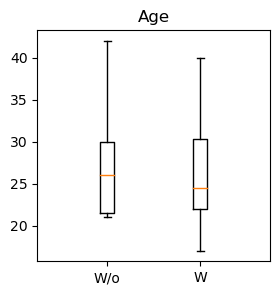

In [16]:
make_bv_plot(["age"], ["Age"], 1, 1, [[15, 55]], w = 3, h = 3, df0 = df_0_q, df1 = df_1_q)

### General task performance

In [17]:
compare(["num_correct"]) 
compare(["time_total", "time_alone", "time_ai"], df0 = df_0_q, df1 = df_1_q)

num_correct 

All
Mean: 6.630434782608695
Std: 6.630434782608695
Min & Max: 3 10


Group 0
Mean: 6.304347826086956
Std: 6.304347826086956
Min & Max: 3 10


Group 1
Mean: 6.956521739130435
Std: 6.956521739130435
Min & Max: 4 10


Ttest_indResult(statistic=-2.173925518371905, pvalue=0.0398007783772601)

---

time_total 

All
Mean: 291.0135743166949
Std: 291.0135743166949
Min & Max: 88.39004898071289 869.6293022632599


Group 0
Mean: 210.86762437067534
Std: 210.86762437067534
Min & Max: 88.39004898071289 419.896653175354


Group 1
Mean: 375.6120770374934
Std: 375.6120770374934
Min & Max: 138.51108479499817 869.6293022632599


Ttest_indResult(statistic=-4.220474924161823, pvalue=0.0003014272219125771)

---

time_alone 

All
Mean: 117.17311478305507
Std: 117.17311478305507
Min & Max: 17.336584091186523 490.4555776119232


Group 0
Mean: 69.29656321124027
Std: 69.29656321124027
Min & Max: 17.336584091186523 210.50182175636292


Group 1
Mean: 167.70947477552625
Std: 167.70947477552625
Min & Ma

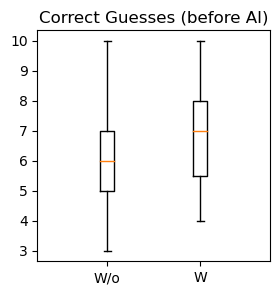

In [18]:
make_bv_plot(["num_correct"], ["Correct Guesses (before AI)"], 1, 1, [[-1, 11]], w = 3, h = 3)

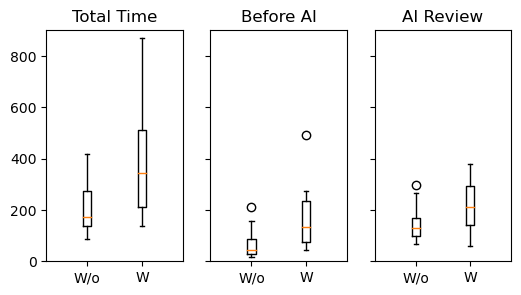

In [19]:
make_bv_plot(["time_total", "time_alone", "time_ai"], ["Total Time", "Before AI", "AI Review"], 1, 3, [[0, 900]], w = 6, h = 3, df0 = df_0_q, df1 = df_1_q)

## Misleading AI

In [20]:
df_1.columns

Index(['group', 'file', 'questionnaire', 'num_correct', 'num_correct_ai',
       'num_mislead', 'num_mislead_switch', 'num_incorrect', 'num_help',
       'num_help_switch', 'num_total_disagree', 'num_total_switch',
       'ratio_switch', 'ratio_help', 'ratio_mislead', 'time_alone', 'time_ai',
       'time_total', 'AI_successful', 'euro_watcher', 'song_knowledge',
       'song_knowledge_which', 'AI_knowledge', 'AI_knowledge_what', 'age',
       'gender', 'AI_answer_basis', 'AI_plausibility'],
      dtype='object')

In [21]:
compare(["ratio_switch", "ratio_help", "ratio_mislead"])

ratio_switch 

All
Mean: 0.07717391304347826
Std: 0.07717391304347826
Min & Max: 0.0 0.75


Group 0
Mean: 0.11304347826086959
Std: 0.11304347826086959
Min & Max: 0.0 0.5


Group 1
Mean: 0.041304347826086954
Std: 0.041304347826086954
Min & Max: 0.0 0.75


Ttest_indResult(statistic=2.0129451189607863, pvalue=0.055468652377269646)

---

ratio_help 

All
Mean: 0.1125
Std: 0.1125
Min & Max: 0.0 1.0


Group 0
Mean: 0.175
Std: 0.175
Min & Max: 0.0 1.0


Group 1
Mean: 0.05
Std: 0.05
Min & Max: 0.0 1.0


Ttest_indResult(statistic=1.6866245780682718, pvalue=0.10463333075690362)

---

ratio_mislead 

All
Mean: 0.07427536231884056
Std: 0.07427536231884056
Min & Max: 0.0 0.5


Group 0
Mean: 0.11231884057971013
Std: 0.11231884057971013
Min & Max: 0.0 0.5


Group 1
Mean: 0.03623188405797101
Std: 0.03623188405797101
Min & Max: 0.0 0.5


Ttest_indResult(statistic=1.5383726074785766, pvalue=0.13703883478878978)

---



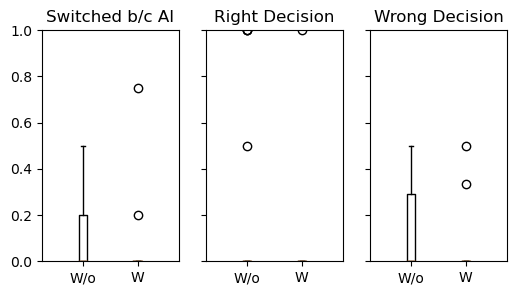

In [22]:
make_bv_plot(["ratio_switch", "ratio_help", "ratio_mislead"], ["Switched b/c AI", "Right Decision", "Wrong Decision"], 1, 3, [[0, 1]], w = 6, h = 3)

In [23]:
print(len(df_0), len(df_1))

print(len(df_0[df_0["num_total_switch"] != 0]))
print(len(df_1[df_1["num_total_switch"] != 0]))

print(len(df_0[df_0["num_mislead_switch"] != 0]))
print(len(df_1[df_1["num_mislead_switch"] != 0]))

print(len(df_0[df_0["num_help_switch"] != 0]))
print(len(df_1[df_1["num_help_switch"] != 0]))

23 23
8
2
7
2
4
1


In [24]:
df_0[["num_correct", "num_correct_ai"]]

,num_correct,num_correct_ai
0,4,3
1,6,5
2,7,7
3,9,9
4,6,6
5,4,4
6,6,6
7,3,3
8,6,6
9,5,5


In [25]:
df_1[["num_correct", "num_correct_ai"]]

,num_correct,num_correct_ai
23,7,7
24,6,5
25,6,6
26,7,7
27,10,10
28,8,8
29,4,4
30,7,7
31,10,10
32,8,8


num_correct 

All
Mean: 6.630434782608695
Std: 6.630434782608695
Min & Max: 3 10


Group 0
Mean: 6.304347826086956
Std: 6.304347826086956
Min & Max: 3 10


Group 1
Mean: 6.956521739130435
Std: 6.956521739130435
Min & Max: 4 10


Ttest_indResult(statistic=-2.173925518371905, pvalue=0.0398007783772601)

---

num_correct_ai 

All
Mean: 6.586956521739131
Std: 6.586956521739131
Min & Max: 3 10


Group 0
Mean: 6.217391304347826
Std: 6.217391304347826
Min & Max: 3 10


Group 1
Mean: 6.956521739130435
Std: 6.956521739130435
Min & Max: 4 10


Ttest_indResult(statistic=-1.8143623956355472, pvalue=0.08214317710375475)

---



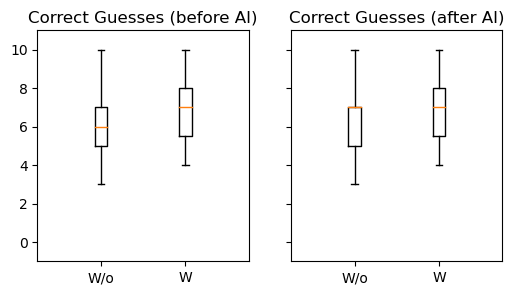

In [26]:
compare(["num_correct", "num_correct_ai"]) 
make_bv_plot(["num_correct", "num_correct_ai"], ["Correct Guesses (before AI)", "Correct Guesses (after AI)"], 1, 2, [[-1, 11]], w = 6, h = 3)

## What do people think?

In [27]:
df_data.columns

Index(['group', 'file', 'questionnaire', 'num_correct', 'num_correct_ai',
       'num_mislead', 'num_mislead_switch', 'num_incorrect', 'num_help',
       'num_help_switch', 'num_total_disagree', 'num_total_switch',
       'ratio_switch', 'ratio_help', 'ratio_mislead', 'time_alone', 'time_ai',
       'time_total', 'AI_successful', 'euro_watcher', 'song_knowledge',
       'song_knowledge_which', 'AI_knowledge', 'AI_knowledge_what', 'age',
       'gender', 'AI_answer_basis', 'AI_plausibility'],
      dtype='object')

In [28]:
compare(["AI_successful", "euro_watcher"], df0 = df_0_q, df1 = df_1_q)

AI_successful 

All
Mean: -0.13513513513513514
Std: -0.13513513513513514
Min & Max: -2.0 1.0


Group 0
Mean: 0.05263157894736842
Std: 0.05263157894736842
Min & Max: -1.0 1.0


Group 1
Mean: -0.3333333333333333
Std: -0.3333333333333333
Min & Max: -2.0 1.0


Ttest_indResult(statistic=0.4962368250971287, pvalue=0.6242417009316892)

---

euro_watcher 

All
Mean: 0.2702702702702703
Std: 0.2702702702702703
Min & Max: -2.0 2.0


Group 0
Mean: 0.47368421052631576
Std: 0.47368421052631576
Min & Max: -2.0 2.0


Group 1
Mean: 0.05555555555555555
Std: 0.05555555555555555
Min & Max: -2.0 2.0


Ttest_indResult(statistic=0.8503835616389483, pvalue=0.4035162579125585)

---



In [29]:
def count_likert(key):
    results = {}
    answers_0 = Counter(df_0_q[key])
    counts_0 = []
    answers_1 = Counter(df_1_q[key])
    counts_1 = []
    for i in range(-2,3):
        if i in answers_0:
            counts_0.append(answers_0[i])
        else:
            counts_0.append(0)
        if i in answers_1:
            counts_1.append(answers_1[i])
        else:
            counts_1.append(0)
    percs_0 = [c/sum(counts_0) for c in counts_0]
    percs_1 = [c/sum(counts_1) for c in counts_1]
    results["Group 0"] = percs_0
    results["Group 1"] = percs_1
    return results
    
results_ai = count_likert("AI_successful")
category_names_ai_reverse = ["VERY LIKELY", "LIKELY", "NEUTRAL", "UNLIKELY", "VERY UNLIKELY"]
category_names_ai = [category_names_ai_reverse[len(category_names_ai_reverse)-(i+1)] for i in range(len(category_names_ai_reverse))]
print(results_ai)
print(category_names_ai)

results_euro = count_likert("euro_watcher")
category_names_euro_reverse = ["EVERY YEAR", "MOST YEARS", "SOMETIMES", "RARELY", "NEVER"]
category_names_euro = [category_names_euro_reverse[len(category_names_euro_reverse)-(i+1)] for i in range(len(category_names_euro_reverse))]
print(results_euro)
print(category_names_euro)

{'Group 0': [0.0, 0.2631578947368421, 0.42105263157894735, 0.3157894736842105, 0.0], 'Group 1': [0.05555555555555555, 0.4444444444444444, 0.2777777777777778, 0.2222222222222222, 0.0]}
['VERY UNLIKELY', 'UNLIKELY', 'NEUTRAL', 'LIKELY', 'VERY LIKELY']
{'Group 0': [0.10526315789473684, 0.21052631578947367, 0.15789473684210525, 0.15789473684210525, 0.3684210526315789], 'Group 1': [0.2222222222222222, 0.2222222222222222, 0.16666666666666666, 0.05555555555555555, 0.3333333333333333]}
['NEVER', 'RARELY', 'SOMETIMES', 'MOST YEARS', 'EVERY YEAR']


[0.         0.05555556] [0. 0.]
[0.26315789 0.44444444] [0.         0.05555556]
[0.42105263 0.27777778] [0.26315789 0.5       ]
[0.31578947 0.22222222] [0.68421053 0.77777778]
[0. 0.] [1. 1.]


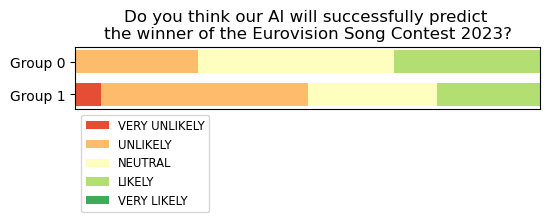

In [30]:
survey(results_ai, category_names_ai,"ai_success", "Do you think our AI will successfully predict \nthe winner of the Eurovision Song Contest 2023?", height = 0.8)

[0.10526316 0.22222222] [0. 0.]
[0.21052632 0.22222222] [0.10526316 0.22222222]
[0.15789474 0.16666667] [0.31578947 0.44444444]
[0.15789474 0.05555556] [0.47368421 0.61111111]
[0.36842105 0.33333333] [0.63157895 0.66666667]


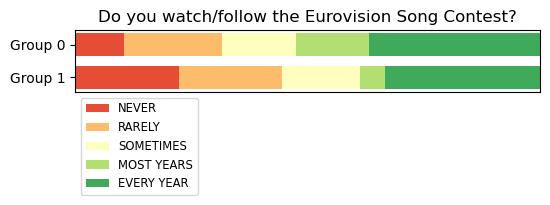

In [31]:
survey(results_euro, category_names_euro,"euro_watcher", "Do you watch/follow the Eurovision Song Contest?", height = 0.8)

In [37]:
ai_k_0 = list(Counter(df_0_q["AI_knowledge"]).values())
ai_k_0 = [ai_k_0[len(ai_k_0)-(i+1)] for i in range(len(ai_k_0))]
ai_k_1 = list(Counter(df_1_q["AI_knowledge"]).values())
ai_k_1 = [ai_k_1[len(ai_k_1)-(i+1)] for i in range(len(ai_k_1))]

so_k_0 = list(Counter(df_0_q["song_knowledge"]).values())
so_k_0 = [so_k_0[len(so_k_0)-(i+1)] for i in range(len(so_k_0))]
so_k_1 = list(Counter(df_1_q["song_knowledge"]).values())
so_k_1 = [so_k_1[len(so_k_1)-(i+1)] for i in range(len(so_k_1))]

results_AI_k = {"Group 0":[i/sum(ai_k_0) for i in ai_k_0], "Group 1":[i/sum(ai_k_1) for i in ai_k_1]}
results_song_k = {"Group 0":[i/sum(so_k_0) for i in so_k_0], "Group 1":[i/sum(so_k_1) for i in so_k_1]}

print(results_AI_k)
print(results_song_k)

Counter(df_0_q["song_knowledge"])

{'Group 0': [0.21052631578947367, 0.7894736842105263], 'Group 1': [0.3888888888888889, 0.6111111111111112]}
{'Group 0': [0.47368421052631576, 0.5263157894736842], 'Group 1': [0.4444444444444444, 0.5555555555555556]}


Counter({'YES': 10, 'NO': 9})

[0.21052632 0.38888889] [0. 0.]
[0.78947368 0.61111111] [0.21052632 0.38888889]


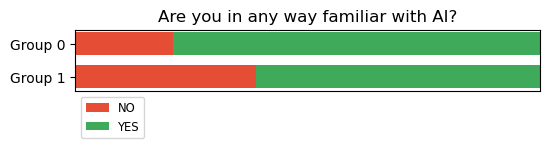

In [36]:
survey(results_AI_k, ["NO", "YES"], "ai_knowledge", "Are you in any way familiar with AI?", height = 0.8)

[0.47368421 0.44444444] [0. 0.]
[0.52631579 0.55555556] [0.47368421 0.44444444]


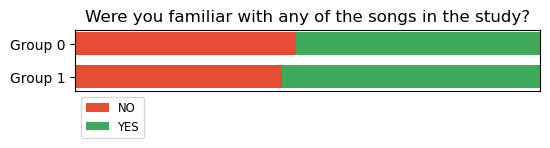

In [38]:
survey(results_song_k, ["NO", "YES"], "song_knowledge", "Were you familiar with any of the songs in the study?", height = 0.8)

In [39]:
df_0_q.columns

Index(['group', 'file', 'questionnaire', 'num_correct', 'num_correct_ai',
       'num_mislead', 'num_mislead_switch', 'num_incorrect', 'num_help',
       'num_help_switch', 'num_total_disagree', 'num_total_switch',
       'ratio_switch', 'ratio_help', 'ratio_mislead', 'time_alone', 'time_ai',
       'time_total', 'AI_successful', 'euro_watcher', 'song_knowledge',
       'song_knowledge_which', 'AI_knowledge', 'AI_knowledge_what', 'age',
       'gender', 'AI_answer_basis', 'AI_plausibility'],
      dtype='object')

In [52]:
df_qual = df_1_q
df_qual = df_qual.set_index("file")
print(len(df_qual))

18


In [41]:
AI_answer_basis = {
    '1_1.csv': ["data", "historical data"],
    '1_18.csv': ["data", "expert data"],
    '1_2.csv': ["lyrics", "lyrics resonate"],
    '1_3.csv': ["AI/ML"],
    '1_22.csv': ["data", "statistics"],
    '1_23.csv': ["lyrics"],
    '1_6.csv': ["data", "historical data"],
    '1_21.csv': ["lyrics", "lyrics resonate"],
    '1_20.csv': ["AI/ML"],
    '1_5.csv': ["lyrics"],
    '1_11.csv': ["lyrics"],
    '1_16.csv': ["country of singer"],
    '1_14.csv': ["lyrics"]
}

df_qual["AI_answer_basis_codes"] = pd.Series(AI_answer_basis)

AI_plausibility = {
    '1_1.csv': ["comparable to human"],
    '1_18.csv': ["plausible", "fairly plausible"],
    '1_2.csv': ["basis", "basis contradictory"],
    '1_3.csv': ["plausible", "very plausible"],
    '1_22.csv': ["comparable to human"],
    '1_23.csv': ["basis", "basis not sufficient"],
    '1_6.csv': ["plausible", "very plausible"],
    '1_21.csv': ["plausible", "somewhat plausible"],
    '1_20.csv': ["unsure"],
    '1_5.csv': ["plausible", "fairly plausible", "basis", "basis not sufficient"],
    '1_11.csv': ["not plausible", "basis", "basis not sufficient"],
    '1_16.csv': ["unsure"],
    '1_14.csv': ["plausible", "fairly plausible"]
}

df_qual["AI_plausibility_codes"] = pd.Series(AI_plausibility)

In [42]:
for i, row in df_qual.iterrows():
    print(i)
    print(row['num_mislead'],"-->", row['num_mislead_switch'])
    print(row['num_help'], "-->", row['num_help_switch'])
    print(row["AI_successful"])
    print("-",row["AI_answer_basis"], row["AI_answer_basis_codes"])
    print("-",row["AI_plausibility"], row["AI_plausibility_codes"])
    print("---")

1_1.csv
3 --> 0
1 --> 0
1.0
- All past songs used in the ESC ['data', 'historical data']
- What an average person trying to convince me would say whether it's true or not ['comparable to human']
---
1_18.csv
3 --> 1
2 --> 0
-1.0
- Professional critique and analysis ['data', 'expert data']
- Fairly plausible ['plausible', 'fairly plausible']
---
1_19.csv
3 --> 0
2 --> 0
-1.0
- nan nan
- nan nan
---
1_0.csv
3 --> 0
1 --> 0
0.0
- nan nan
- nan nan
---
1_2.csv
5 --> 0
0 --> 0
-2.0
- In those AI answers were many conclusions about the lyrics and how theyve inflicted the viewers choice. ['lyrics', 'lyrics resonate']
- When sung in native language the AI referred to it in one case as exotic and also built up their verdict on the emotions the lyrics were transmitting. This is kinda contradictory imo. ['basis', 'basis contradictory']
---
1_3.csv
4 --> 0
1 --> 0
0.0
- the possibility to gain and use more information about a subject than a human itself  ['AI/ML']
- Very plausible  ['plausible', '

In [43]:
plaus_codes = list(AI_plausibility.values())
plaus_codes = sum(plaus_codes, [])
print(set(plaus_codes))
plaus_codes = Counter(plaus_codes)
plaus_codes = sorted(list(plaus_codes.items()), key = lambda x: x[1], reverse = True)
for item in plaus_codes:
    print(item[0], ":", item[1])

{'basis contradictory', 'basis', 'not plausible', 'basis not sufficient', 'somewhat plausible', 'fairly plausible', 'comparable to human', 'unsure', 'plausible', 'very plausible'}
plausible : 6
basis : 4
fairly plausible : 3
basis not sufficient : 3
comparable to human : 2
very plausible : 2
unsure : 2
basis contradictory : 1
somewhat plausible : 1
not plausible : 1


[0 2 2 1 0] [0 0 0 0 0]
[2 0 0 0 3] [0 2 2 1 0]
[3 0 0 0 1] [2 2 2 1 3]
[1 0 0 0 0] [5 2 2 1 4]


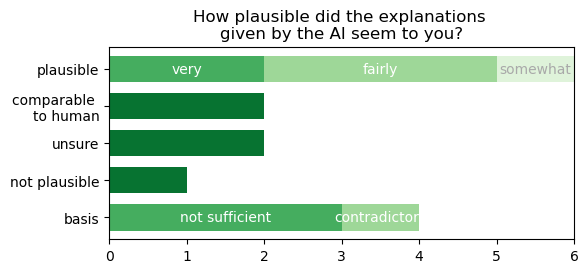

In [51]:
plaus_results = {
    "plausible": [0, 2, 3, 1],
    "comparable \nto human": [2, 0, 0, 0],
    "unsure": [2, 0, 0, 0],
    "not plausible": [1, 0, 0, 0],
    "basis": [0, 3, 1, 0]
}

plaus_bar_labels = [["", "very", "fairly", "somewhat"],
                    ["", "", "", ""],
                    ["", "", "", ""],
                    ["", "", "", ""],
                    ["", "not sufficient", "contradictory", ""]]
plaus_bar_labels = np.array(plaus_bar_labels)
plaus_bar_labels = plaus_bar_labels.T

survey(plaus_results, ["", "", "", ""], "plausible", "How plausible did the explanations \ngiven by the AI seem to you?", height = 2.5, legend = False, x_invisible = False, cmap = "Greens_r", use_bar_labels = True, bar_labels = plaus_bar_labels)



In [45]:
basis_codes = list(AI_answer_basis.values())
basis_codes = sum(basis_codes, [])
print(set(basis_codes))
basis_codes = Counter(basis_codes)
basis_codes = sorted(list(basis_codes.items()), key = lambda x: x[1], reverse = True)
for item in basis_codes:
    print(item[0], ":", item[1])

{'statistics', 'lyrics resonate', 'AI/ML', 'historical data', 'data', 'lyrics', 'country of singer', 'expert data'}
lyrics : 6
data : 4
historical data : 2
lyrics resonate : 2
AI/ML : 2
expert data : 1
statistics : 1
country of singer : 1


[4 1 0 2] [0 0 0 0]
[2 0 2 0] [4 1 0 2]
[0 0 1 0] [6 1 2 2]
[0 0 1 0] [6 1 3 2]


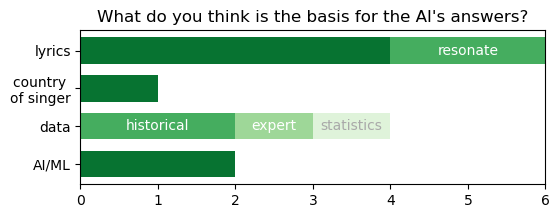

In [50]:
basis_results = {
    "lyrics": [4, 2, 0, 0],
    "country \nof singer": [1, 0, 0, 0],
    "data": [0, 2, 1, 1],
    "AI/ML": [2, 0, 0, 0]
}

basis_bar_labels = [["", "resonate", "", ""],
                    ["", "", "", ""],
                    ["", "historical", "expert", "statistics"],
                    ["", "", "", ""]
                   ]
basis_bar_labels = np.array(basis_bar_labels)
basis_bar_labels = basis_bar_labels.T

survey(basis_results, ["", "", "", ""], "basis", "What do you think is the basis for the AI\'s answers?", height = 2.0, legend = False, x_invisible = False, cmap = "Greens_r", use_bar_labels = True, bar_labels = basis_bar_labels)


